In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [59]:
DATA_DIR = '../data/'

In [60]:
mixer_truck = cv2.imread(DATA_DIR+"mixer_truck.jpg")
road = cv2.imread(DATA_DIR+"road.jpg")

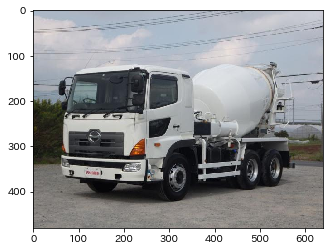

In [61]:
img = cv2.cvtColor(mixer_truck, cv2.COLOR_BGR2RGB)
plt.imshow(img)

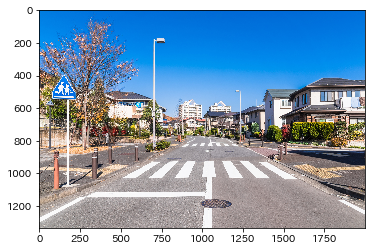

In [62]:
img = cv2.cvtColor(road, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Grab cutによるマスク

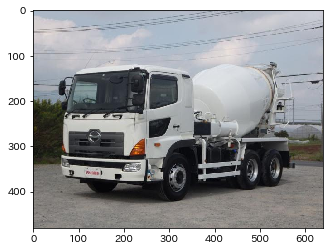

In [63]:
img = cv2.cvtColor(mixer_truck, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Grab-cut 1回目

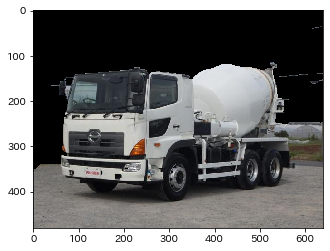

In [65]:
img = cv2.cvtColor(mixer_truck, cv2.COLOR_BGR2RGB)

mask1 = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)  # ここをいじるとエラーになる
fgdModel = np.zeros((1,65),np.float64)  # ここをいじるとエラーになる

rect = (0, 0, img.shape[1]-1, img.shape[0]-1)
cv2.grabCut(img, mask1, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask1==2)|(mask1==0), 0, 1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
mask2 = mask2*255

plt.imshow(img)#,plt.colorbar(),plt.show()

### 上記でマスクされた画像に対して、さらにGrab-cut

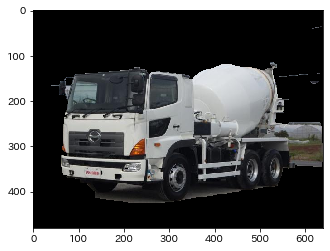

In [66]:
mask1 = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (0,0,img.shape[1]-1,img.shape[0]-1)
cv2.grabCut(img, mask1, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask1==2)|(mask1==0), 0, 1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
mask2 = mask2*255

plt.imshow(img)#,plt.colorbar(),plt.show()

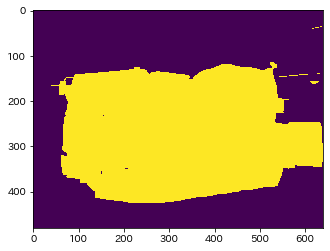

In [67]:
plt.imshow(mask2)

### 上記2つの画像を合成する
- src: ミキサー車を、dst: 道路の画像に貼り付ける
- その際に、ミキサー車のどの部分を貼り付けるかマスク画像によって指定する必要がある

- 合成に関しては、opencvのcv2.seamlessCloneを使用する（ポアソン合成）
    - cv2.seamlessClone(src, dst, mask, center, cv2.NORMAL_CLONE)
    - src: 貼り付ける画像, dst: 貼り付け先の画像, mask: srcの貼り付ける部分のマスク
    - center: 貼り付け先の中心座標

In [68]:
src = deepcopy(mixer_truck)
dst = deepcopy(road)

In [39]:
# # マスク作成
# # マスク用単一色画像を作成
# height = src.shape[0] # 生成画像の高さ
# width = src.shape[1] # 生成画像の幅
# mask = np.full((height, width), 0, dtype=np.uint8)

# # マスク範囲を四角形で描画（今回は画像全体とする）
# boxFromX = 1 #マスク範囲開始位置 X座標
# boxFromY = 1 #マスク範囲開始位置 Y座標
# boxToX = width-1 #マスク範囲終了位置 X座標
# boxToY = height-1 #マスク範囲終了位置 Y座標
# mask = cv2.rectangle(mask, (boxFromX, boxFromY), (boxToX, boxToY),(255), cv2.FILLED)

In [69]:
# grab cutを利用した作成したマスク画像を、合成マスクとして使用
mask = mask2[:]

ポアソン合成してみるが、うまくいかず。。

In [70]:
# src画像のリスケール
size_rate = 1
src_rescale = cv2.resize(src, (int(src.shape[1]*size_rate), int(src.shape[0]*size_rate)))
mask_rescale = cv2.resize(mask, (int(mask.shape[1]*size_rate), int(mask.shape[0]*size_rate)))

print(src_rescale.shape)
print(mask_rescale.shape)

# ポアソン合成
center = (dst.shape[1]//2, dst.shape[0]//2)
output = cv2.seamlessClone(src_rescale, dst, mask_rescale, center, cv2.NORMAL_CLONE)

(480, 640, 3)
(480, 640)


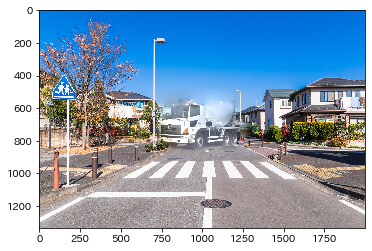

In [71]:
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
plt.imshow(output)

### 物体位置の座標
- 上記で指定したcenterの位置と、rescaleした画像サイズによって決まる, 対応としては下記のようになる:
    - boxFromX = center[0]-src_width//2
    - boxFromY = center[1]-src_height//2
    - boxToX = center[0]+src_width//2
    - boxToY = center[1]+src_height//2

In [ ]:
# 実際に描画してみると、
src_height = src_rescale.shape[0]
src_width = src_rescale.shape[1]

boxFromX = center[0]-src_width//2
boxFromY = center[1]-src_height//2
boxToX = center[0]+src_width//2
boxToY = center[1]+src_height//2

output = cv2.rectangle(output, (boxFromX, boxFromY), (boxToX, boxToY), (0, 0, 0), thickness=3)

In [ ]:
plt.imshow(output)